## Image Data Preprocessing

### 환경 구성

%pip install opencv-python

In [1]:
import os #내 컴퓨터의 file에 접근 가능하게 해줌
import matplotlib.pyplot as plt
import cv2 #OpenCV라는 라이브러리

### Dataset 정리

In [2]:
# 전체 data 불러오기 + train, val, test로 분할
import numpy as np
from sklearn.model_selection import train_test_split

# image resizing, 리스트에 집어넣고, split
def load_all_data(base_dir, img_size=(224, 224)):
    images = [] 
    labels = []
    categories = ['NORMAL', 'PNEUMONIA'] # 카테고리 분류(3-4개면 3~4개의 카테고리 써넣기)
    
    for category in categories: #폴더안의 폴더에 들어가기 위해 루프 3번 돌림
        class_num = categories.index(category) #ls.index(data) -> 리스트 안에 data의 index 값을 반환
        for subset in ['train', 'test', 'val']:
            subset_dir = os.path.join(base_dir, subset, category) #root/datasets/pneumonia  /train  /normal
            for img in os.listdir(subset_dir):
                try:
                    img_path = os.path.join(subset_dir, img) # image 파일의 경로
                    img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) #image array로 불러오기
                    new_array = cv2.resize(img_array, img_size) # img_size에 맞춰서 크기 조정
                    images.append(new_array) #data 다 불러와서 image 라는 리스트에 다 모으고 있음
                    labels.append(class_num)
                except Exception as e:
                    print(f"Error loading image {img}: {e}")
    
    return np.array(images), np.array(labels)

def split_data(X, y, test_size=0.2, val_size=0.2):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size / (1 - test_size), stratify=y_train_val, random_state=42)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

#### Data 불러오기

In [3]:
# 내가 어디서 하고 있는지!! 확인해야합니다
%pwd

'/Users/hx/Env'

In [5]:
base_dir = "Pneumonia"
X, y = load_all_data(base_dir,)
#X에는 내가 다운 받은 영상값 y는 정답값

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y) 
#함수 생성시 기본 값을 적어놨기 때문에 특별한 값을 입력하지 않으면 기본값을 따른다.

print(f"Train data shape : {X_train.shape}, Train labels shape : {y_train.shape}")
print(f"Val data shape : {X_val.shape}, Val labels shape : {y_val.shape}")
print(f"Test data shape : {X_test.shape}, Test labels shape : {y_test.shape}")

Train data shape : (3513, 224, 224), Train labels shape : (3513,)
Val data shape : (1171, 224, 224), Val labels shape : (1171,)
Test data shape : (1172, 224, 224), Test labels shape : (1172,)


### Preparing tutorial

#### Resize

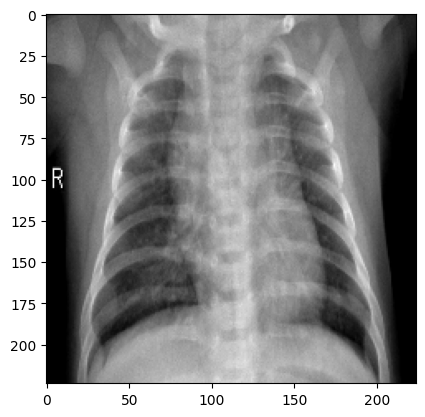

In [ ]:
def resize_img(image, size=(224, 224)):
    return cv2.resize(image, size)

resized_img = resize_img(X_train[708])
plt.imshow(resized_img, cmap='gray')
plt.show()

#### Histogram equalization

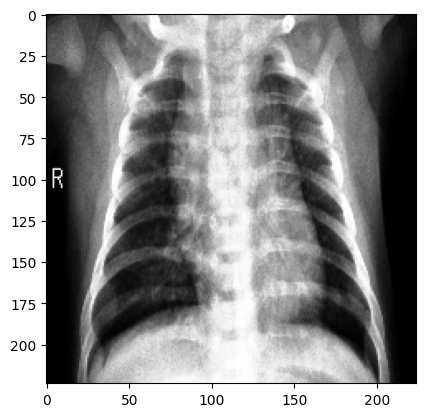

In [ ]:
def he_img(image) :
    return cv2.equalizeHist(image)

equalized_img = he_img(X_train[708])
plt.imshow(equalized_img, cmap='gray')
plt.show()

### Noise Reduction

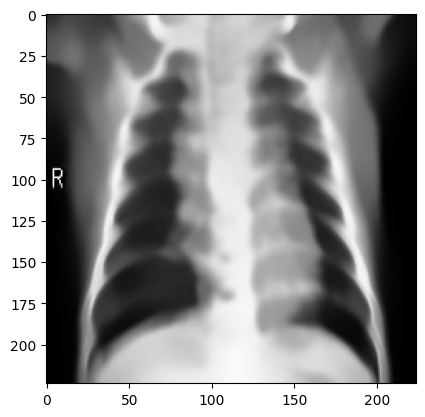

In [ ]:
def noise_reduction(image) :
    return cv2.fastNlMeansDenoising(image, None, 30, 7, 21)

nr_image = noise_reduction(he_img(X_train[708]))
plt.imshow(nr_image, cmap='gray')
plt.show()
# 잘못 denoising 하면 이미지 뿌얘짐 ㅠㅠ (의료 데이터 자체에서는 잘 안 함)

#### Image Normalization (이미지 정규화)

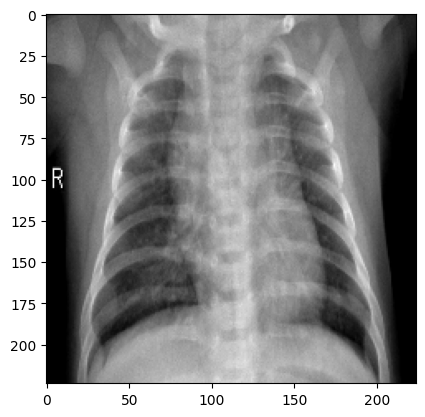

In [ ]:
def normalize_image(image):
    return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    #Minmax Normalization : 메모리를 덜 먹고 overfitting을 방지함
    
normalized_img = normalize_image(X_train[708])
plt.imshow(normalized_img, cmap='gray')
plt.show()

#원본과 다를게 없어 보이지만, 픽셀값의 범위가 달라짐

#### Edge Detection

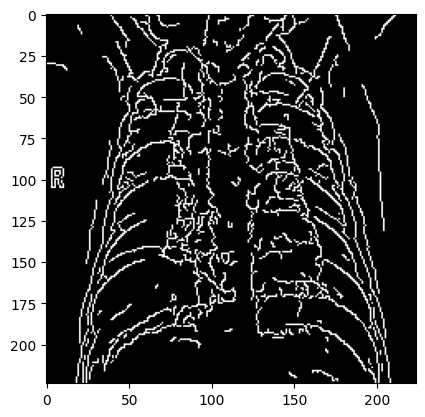

In [ ]:
def detect_edge(image):
    return cv2.Canny(image, 128, 200)

edges = detect_edge(he_img(X_train[708]))
plt.imshow(edges, cmap='gray')
plt.show()

# 범위 안에 있는 값드을 선으로 검출
# 육안으로 안 보이던 것들이 선으로 보임 -> noise
# equalized한 이미지 사용하면 선 더 잘 잡힘

#### Blurring

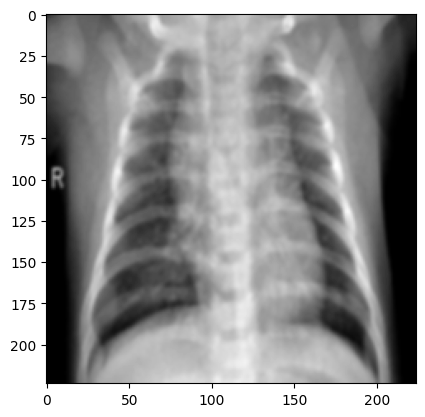

In [ ]:
#흐리게 처리되는 부분을 가우시안 정규분포를 이용해 처리함
def blur_image(image) :
    return cv2.GaussianBlur(image, (5,5), 0)

blurred_img = blur_image(X_train[708])
plt.imshow(blurred_img, cmap='gray')
plt.show()

#### Contour

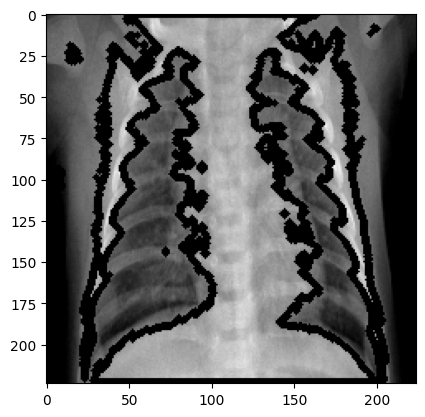

In [ ]:
def contour_image(image):
    ret, thresh = cv2.threshold(image, 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

contours = contour_image(X_train[708])
contour_image = cv2.drawContours(X_train[708].copy(), contours, -1, (0,255,0), 3)
plt.imshow(contour_image,cmap='gray')
plt.show()